For this assignment, predictability is more desirable than interpretability. Thus, the data will be reduced down to its core principal components to compress the data without losing important information, which will increase speed and efficiency when training the model. PCA is an unsupervised ML method that does not require y-labels and essentially clusters parts of the data based on similarity/differences of eigenvalues (inherently present in data).

In [1]:
# Data wrangling
import pandas as pd # data manipulation
import numpy as np # linear algebra

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler

# plots
import matplotlib.pyplot as plt # plots

In [2]:
train_df = pd.read_csv('http://birch.iaa.ncsu.edu/~slrace/DataMining2021/Code/MLProject21_train.csv')
valid_df = pd.read_csv('http://birch.iaa.ncsu.edu/~slrace/DataMining2021/Code/MLProject21_valid.csv')
test_df = pd.read_csv('http://birch.iaa.ncsu.edu/~slrace/DataMining2021/Code/MLProject21_test.csv')

In [3]:
print('Data Dimensions: ', train_df.shape)

# look at column types and identify null values
train_df.info()

# We have 1 bool, 1 categorical, and the rest are numeric
# Let's explore whether we should one-hot encode the categorical var if it's useful

Data Dimensions:  (250000, 130)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 130 entries, v1 to binary.target2
dtypes: bool(1), float64(115), int64(13), object(1)
memory usage: 246.3+ MB


In [4]:
train_df.dtypes[train_df.dtypes=='bool'] # v7 is bool type
train_df.dtypes[train_df.dtypes=='object'] # v45 is object type (categorical)

v45    object
dtype: object

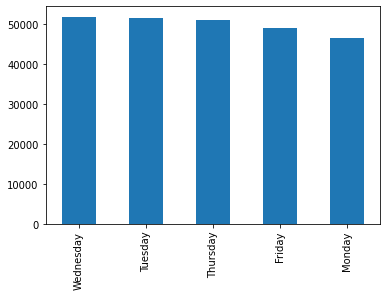

In [5]:
# v7 has all False in training data (not useful for model training)
train_df['v7'].value_counts()

# v45 has evenly distributed levels (not useful)
train_df['v45'].value_counts()
train_df['v45'].value_counts().plot(kind='bar')

Drop non-numeric vars that are not useful

In [6]:
train_df.drop(['v7', 'v45'], axis=1, inplace=True)

Separate out inputs (attributes) and outputs (targets).

In [7]:
# Get inputs and outputs as separate dfs on training data
X_train = train_df.drop(['cont.target', 'binary.target1', 'binary.target2'], axis=1)
y1_train = train_df['cont.target']
y2_train = train_df['binary.target1']
y3_train = train_df['binary.target2']

# Repeat for validation data
X_valid = valid_df.drop(['v7', 'v45', 'cont.target', 'binary.target1', 'binary.target2'], axis=1)
y1_valid = valid_df['cont.target']
y2_valid = valid_df['binary.target1']
y3_valid = valid_df['binary.target2']

# Repeat for test data (targets not provided)
X_test = test_df.drop(['v7', 'v45'], axis=1)

# Convert input and output dfs to arrays for sklearn
train_features = np.array(X_train)
y1_train = np.ravel(np.array(y1_train))
y2_train = np.ravel(np.array(y2_train))
y3_train = np.ravel(np.array(y3_train))

# Repeat for validation data
valid_features = np.array(X_valid)
y1_valid = np.ravel(np.array(y1_valid))
y2_valid = np.ravel(np.array(y2_valid))
y3_valid = np.ravel(np.array(y3_valid))

# Repeat for test data
test_features = np.array(X_test)

# Save feature names for later use
feature_list = list(X_train.columns)

We will be focusing on binary target 2.

# PCA: Dimension Reduction

In [8]:
# scale to standardize training data
ss = StandardScaler()
ss.fit(train_features)
train_norm = pd.DataFrame(ss.transform(train_features), columns=feature_list)

# Define number of components to be used for PCA
pca = PCA(n_components=50)
scores = pca.fit_transform(train_norm)
loadings = pca.components_.T

# Convert scores to df for first 20 PCs
comps = []
for i in range(1,51):
    comps.append("PC{}".format(i))

scores_df = pd.DataFrame(scores, columns=comps)
loadings_df = pd.DataFrame(loadings, columns=comps)

scores_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,-1.051223,-0.490480,-2.830786,1.586082,-0.180288,3.936627,-1.231453,-0.693660,0.333366,0.589109,-0.188926,-0.850707,0.582115,0.025435,-1.209982,1.740863,-0.494242,-1.343676,0.282429,1.146526,0.527848,1.882604,-0.510888,-0.754586,-0.591518,-1.002007,0.049719,0.080348,0.566047,0.657846,-0.517252,0.652430,-1.000066,0.246602,0.505857,-1.123341,-0.598824,0.883925,-0.134938,0.205982,0.238645,0.314293,-0.144666,-0.341905,-1.444771,0.494911,0.614960,0.133223,0.613179,0.529605
1,-1.175759,-0.609709,-2.769796,1.340526,-0.042229,3.879008,-1.343777,-0.825517,0.232781,0.543311,0.126410,-0.330674,0.476777,0.105271,-1.023455,1.869187,-0.660899,-1.358626,0.203681,0.993406,0.319601,1.976916,-0.733259,-0.365340,-0.210832,-1.397493,0.065016,0.220514,0.708793,0.817462,-0.981801,1.035963,-0.835172,0.208765,0.624210,-0.734323,-0.919429,0.849145,-0.140661,1.099320,0.912414,-0.517801,-0.943616,-0.128624,-1.638888,-0.048388,1.139139,0.406281,0.797205,-0.044415
2,-1.410161,-1.095514,-3.253264,2.740190,-0.016974,3.796829,-1.580450,-0.942198,0.159395,1.106371,-0.268074,-0.371949,0.267790,1.050509,-1.425967,1.599097,-0.594515,-1.544639,0.260692,1.170831,0.606065,1.333176,-0.443326,-0.560737,-0.776717,-0.703961,0.070562,0.035829,0.428792,0.595092,0.405582,0.732177,-0.707699,0.004918,0.376289,-1.692758,-0.747926,0.494762,-0.264414,0.142241,-0.301140,1.030191,-0.155111,0.269981,-1.227454,0.309586,0.463860,-0.136206,0.628572,0.209501
3,-0.601265,0.373352,-1.704723,-0.651583,0.123363,4.014871,-1.113260,-1.026959,0.551917,0.328737,0.176022,-1.778166,1.366633,-2.269306,-0.972224,2.214612,-0.319227,-1.379657,0.221339,1.073029,0.188035,1.833653,-0.440467,-0.241082,-0.434503,-0.651000,0.197562,0.523121,0.760009,0.381121,-0.618806,0.667070,-0.798390,1.322083,1.007941,-0.261031,-1.907042,0.696633,-0.890668,-0.065892,-1.106610,-0.172726,-0.431663,-0.205486,-1.486136,0.295580,1.159262,0.531119,0.455098,0.232496
4,-1.004777,0.110095,-1.886783,-0.759187,-0.429035,4.109451,-0.915566,-1.155547,-0.002620,-0.919906,0.362761,-0.561838,0.526362,-0.617138,-0.998854,2.208690,-1.417325,-0.520432,0.364662,1.047695,0.141634,2.300386,-0.011376,0.059765,0.548740,-1.258242,0.066869,0.462642,0.701519,0.598294,-0.511247,0.457428,-1.180133,0.660217,0.853454,-0.673037,-1.602119,0.497962,-0.691852,0.496704,-0.610517,-0.125398,-0.432942,-0.130673,-1.416208,0.091668,1.187412,-0.065277,-0.377425,0.712853


In [9]:
# Explained Variance per PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

# Combine df of PC, explained variance, cumulative variance
pc_df = pd.DataFrame(comps, columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)

df_explained_variance.head()

,PC,Explained Variance,Cumulative Variance
0,PC1,0.192524,0.193
1,PC2,0.108725,0.302
2,PC3,0.071296,0.373
3,PC4,0.055876,0.429
4,PC5,0.031659,0.461


View Scree Plot

Text(0, 0.5, 'Eigenvalue')

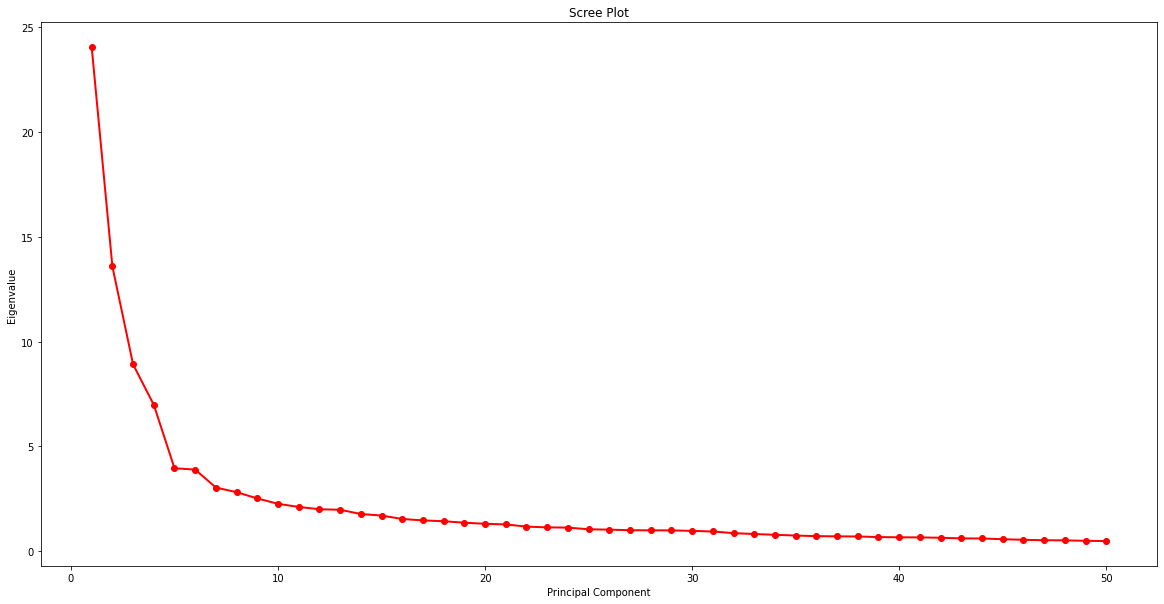

In [10]:
fig = plt.figure(figsize=(20,10))
PC_vals = np.arange(50) + 1
plt.plot(PC_vals, pca.explained_variance_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

The Scree Plot shows us how much explained variance is contributed by each principal component. From the plot, there is a clear "elbow" around 10 PCs, which means we can reduce the data down to the first 10 PCs to compress the data without losing important information.

In [11]:
# Reduce data dimension to 10 PCs
reduced_pca = PCA(n_components=10)
reduced_train = reduced_pca.fit_transform(train_norm)

reduced_comps = []
for i in range(1,11):
    reduced_comps.append("PC{}".format(i))

reduced_train = pd.DataFrame(reduced_train, columns=reduced_comps)
reduced_loadings = reduced_pca.components_.T
reduced_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.051223,-0.490481,-2.830787,1.586087,-0.180749,3.936731,-1.232652,-0.691897,0.334269,0.617943
1,-1.175759,-0.609709,-2.769797,1.340529,-0.042654,3.879046,-1.345005,-0.824415,0.234918,0.568680
2,-1.410161,-1.095515,-3.253265,2.740192,-0.017351,3.796880,-1.581087,-0.940228,0.159737,1.132395
3,-0.601265,0.373352,-1.704724,-0.651581,0.122970,4.014944,-1.114505,-1.026277,0.552015,0.347672
4,-1.004777,0.110094,-1.886783,-0.759184,-0.429633,4.109267,-0.913623,-1.154223,0.001244,-0.907547


## Prepare validation data for scoring with training data
- Replicate standardization and data reduction steps from working with training data
- Use training data mean and loadings to standardize validation data

In [12]:
# standardize validation data using training mean and std
v_scale = (valid_features - train_features.mean(axis=0))/train_features.std(axis=0, dtype=np.float64)
valid_norm = pd.DataFrame(v_scale, columns=feature_list)

# get 10 PCs using training loadings
reduced_valid = pd.DataFrame(np.matmul(v_scale, reduced_loadings), columns=reduced_comps)
reduced_valid.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.198308,-9.392109,-0.658277,1.239934,1.944853,-3.742387,0.934073,-3.010240,0.728508,1.682507
1,0.928094,-9.224510,-1.045991,1.256918,1.417890,-3.804866,1.043314,-2.472256,0.938388,2.380795
2,0.834377,-9.516810,-1.094164,1.664480,1.512342,-3.783873,0.933903,-2.755230,0.603287,1.689857
3,0.560771,-10.006776,-1.059451,1.795591,2.092857,-3.843692,0.626436,-2.959318,0.763884,2.517782
4,1.918714,-7.954106,0.664240,-1.323783,2.218978,-3.659937,1.183309,-2.799352,1.133254,1.205099


## Prepare test data for scoring with training+validation data
- Replicate standardization and data reduction steps from training and validation data
- Use training + validation mean and loadings to standardize test data

In [13]:
# Combine training and validation data into a single df (then convert to array)
train_valid = pd.concat([X_train, X_valid], axis=0)
train_valid_features = np.array(train_valid)

# scale to standardize training+validation data
ss = StandardScaler()
ss.fit(train_valid_features)
train_valid_norm = pd.DataFrame(ss.transform(train_valid_features), columns=feature_list)

# Reduce training+validation data dimension to 10 PCs
reduced_pca = PCA(n_components=10)
reduced_train_valid = reduced_pca.fit_transform(train_valid_norm)
reduced_train_valid = pd.DataFrame(reduced_train_valid, columns=reduced_comps)
train_valid_loadings = reduced_pca.components_.T

# standardize test data using training+validation mean and std
test_scale = (test_features-train_valid_features.mean(axis=0))/train_valid_features.std(axis=0, dtype=np.float64)
test_norm = pd.DataFrame(test_scale, columns=feature_list)

# get 10 PCs using training+validation loadings
reduced_test = pd.DataFrame(np.matmul(test_scale, train_valid_loadings), columns=reduced_comps)

### Export Reduced Data
- Add target (binary target 2) back to reduced data
- Export reduced data for later use

In [ ]:
reduced_train = pd.concat([reduced_train, train_df['binary.target2']], axis=1)
reduced_valid = pd.concat([reduced_valid, valid_df['binary.target2']], axis=1)

# NOTE: test data does not provide target

reduced_train.to_csv(r'C:\Users\chely\Documents\Fall 3\ML\Final Project\reduced_train.csv')
reduced_valid.to_csv(r'C:\Users\chely\Documents\Fall 3\ML\Final Project\reduced_valid.csv')
reduced_test.to_csv(r'C:\Users\chely\Documents\Fall 3\ML\Final Project\reduced_test.csv')